In [1]:
import numpy as np
import functools
import gpflow as gpf
import matplotlib.pyplot as plt

from tqdm import trange, tqdm
from IPython import display
from scipy.interpolate import CubicSpline

from Tracking_LQR import generate_control, LQR_tracking_gain, PlanarQuadrotor
from quad_animation import animate_2D_quad
from Quadcopter import SymbolicFuncs
from rd_learner import RDLearner

In [2]:
# constants
dt = 0.01  # integration step
N = 8      # number of states
M = 2      # number of controls

In [3]:
sym_funcs = SymbolicFuncs()
f_full = sym_funcs["f_full"]
f_un = sym_funcs["f_un"]

## Generate Control Law

In [4]:
rotor = PlanarQuadrotor(m_Q=2., Iyy=0.01, d=0.25, m_p=0.)
K = LQR_tracking_gain(np.zeros(6), dt, rotor)
get_control = functools.partial(generate_control, K=K, quad=rotor)

## Simulate

In [5]:
# random waypoint generation
np.random.seed(42)
num_wp = 41
wp_dt = 120

num_steps = (num_wp - 1) * wp_dt
ts = np.arange(num_steps) * dt

wp_ts = np.arange(num_wp) * wp_dt * dt
wp_xs, wp_ys = np.random.uniform(-4, 4, size=(2, num_wp))

In [6]:
# smoothed cublic spline trajectory
cs_x = CubicSpline(wp_ts, wp_xs)
cs_y = CubicSpline(wp_ts, wp_ys)

goal_t6 = np.zeros((num_steps, 6))
goal_t6[:, 0] = cs_x(ts)
goal_t6[:, 1] = cs_y(ts)

In [7]:
# noisy params
R_scale = np.array([.18, .18, .036, .09, .24, .24, .12, .24])
Q_scale = R_scale * .02

In [8]:
# initial state starting at origin
states = np.zeros((num_steps, N))
controls = np.zeros((num_steps, M))

In [9]:
for i in trange(1, num_steps):
    # 8-state to 6-state
    state_6 = states[i-1][[0, 1, 2, 4, 5, 6]]
    controls[i-1] = get_control(state_6, goal_t6[i]).flatten()
    states[i] = f_full(states[i-1], controls[i-1]).flatten()
    states[i] += np.random.normal(scale=Q_scale)
measures = states + np.random.normal(scale=R_scale, size=(num_steps, R_scale.shape[0]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4799/4799 [00:00<00:00, 21157.06it/s]


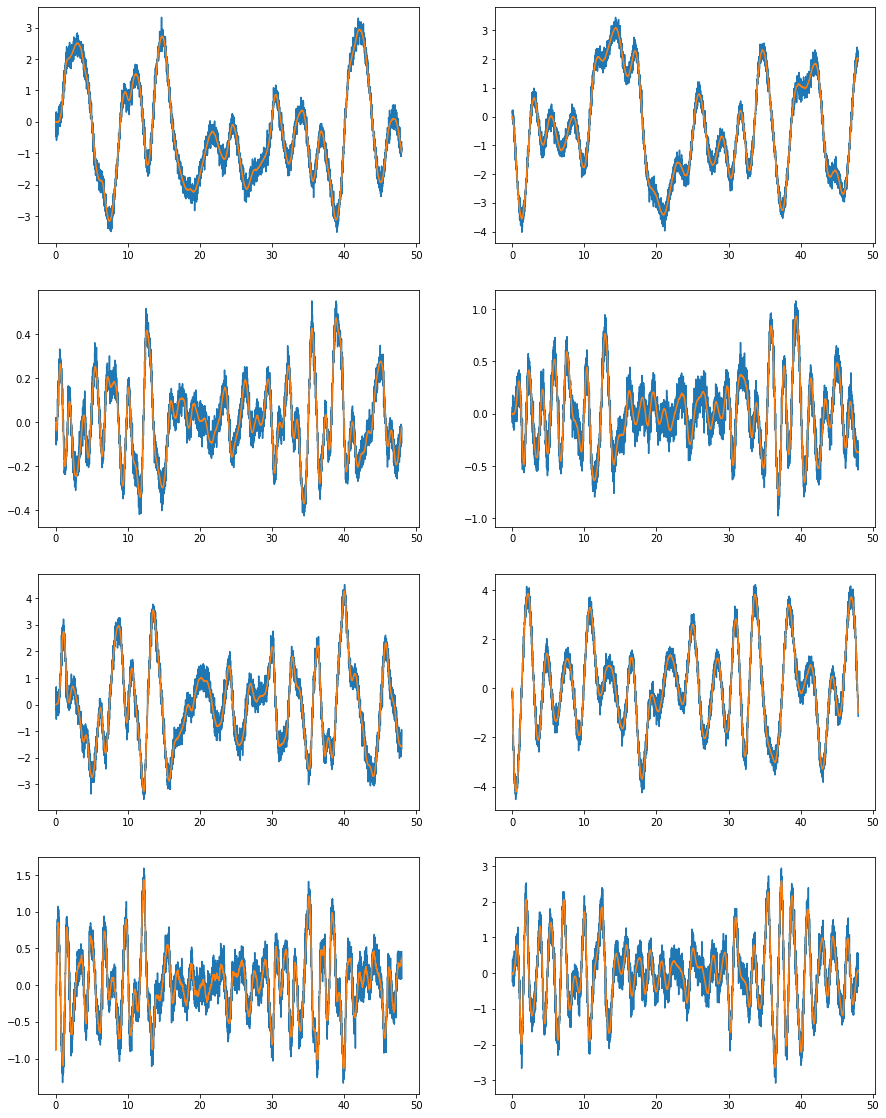

In [10]:
plt.figure(figsize=(15, 20))
for i in range(N):
    plt.subplot(4, 2, i+1)
    plt.plot(ts, measures[:, i])
    plt.plot(ts, states[:, i])

In [11]:
_, anim = animate_2D_quad(ts, states, frameDelay=10)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

## Dynamics Learning

In [12]:
from importlib import reload
import rd_learner

rd_learner = reload(rd_learner)

In [13]:
# nominal dynamics rapper
f_nominal = lambda x, u: f_un(x, u).flatten()

In [14]:
rdl = rd_learner.RDLearner(state_dim=8, control_dim=2, nominal_model=f_nominal, num_induced_points=150, batch_size=500)

In [15]:
rdl.add_data(measures, controls)

2022-05-30 21:47:12.199827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 21:47:12.227903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 21:47:12.228131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 21:47:12.228837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
# fixed likelihood noise model
# rdl.model.likelihood.variances.assign(2 * R_scale ** 2)
# gpf.utilities.set_trainable(rdl.model.likelihood.variances, False)

Start optimizing with existing data buffer...


  0%|                                                                                                                                                  | 0/1400 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'base_conditional_args_to_map' can't be nonlocal (__autograph_generated_file8uybac2a.py, line 23)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'base_conditional_args_to_map' can't be nonlocal (__autograph_generated_file8uybac2a.py, line 23)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use fn_output_signature instead


2022-05-30 21:47:27.384861: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1ec1b470
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1400/1400 [02:02<00:00, 11.38it/s]


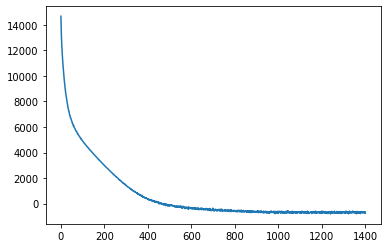

In [17]:
losses = rdl.optimize(1400, adam_lr=1e-2, nat_lr=3e-2)
plt.plot(losses)

In [18]:
losses[-10:]

array([-702.1237486 , -666.53980462, -701.53284972, -685.4776287 ,
       -698.96087336, -754.27729456, -672.12162615, -680.6387778 ,
       -766.98870655, -671.36192016])

In [19]:
R_scale ** 2

array([0.0324  , 0.0324  , 0.001296, 0.0081  , 0.0576  , 0.0576  ,
       0.0144  , 0.0576  ])

In [20]:
rdl.model.likelihood.variances.numpy() / 2

array([0.03196389, 0.03279148, 0.00129513, 0.00807646, 0.05849674,
       0.05801864, 0.01411591, 0.05709117])

In [21]:
rdl.model.mean_function.trainable_variables

(<tf.Variable 'Variable:0' shape=(8,) dtype=float64, numpy=
 array([-0.0025951 , -0.00387723, -0.00044417, -0.00332911, -0.00168491,
        -0.02626595,  0.00656428, -0.00692972])>,)

## Learned GP with UKF

In [59]:
# simulate some figure 8
num_steps = 600
ts = np.arange(num_steps) * dt
ts_ang = 1.2 * 2 * np.pi * ts / (num_steps * dt)

states_tn = np.zeros((num_steps, N))
states_nom_tn = np.zeros_like(states_tn)
controls_tm = np.zeros((num_steps, M))
goal_t6 = np.zeros((num_steps, 6))
goal_t6[:, 0] = 3 * np.sin(ts_ang)
goal_t6[:, 1] = 3 * np.cos(ts_ang) * np.sin(ts_ang)

In [60]:
for i in trange(1, num_steps):
    # loaded trajectory
    state_6 = states_tn[i-1][[0, 1, 2, 4, 5, 6]]
    controls_tm[i-1] = get_control(state_6, goal_t6[i]).flatten()
    states_tn[i] = f_full(states_tn[i-1], controls_tm[i-1]).flatten()
    states_tn[i] += np.random.normal(scale=Q_scale)
    
    # unloaded trajectory
    states_nom_tn[i] = f_un(states_nom_tn[i-1], controls_tm[i-1]).flatten()
measures_tn = states_tn + np.random.normal(scale=R_scale, size=(num_steps, R_scale.shape[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 14147.13it/s]


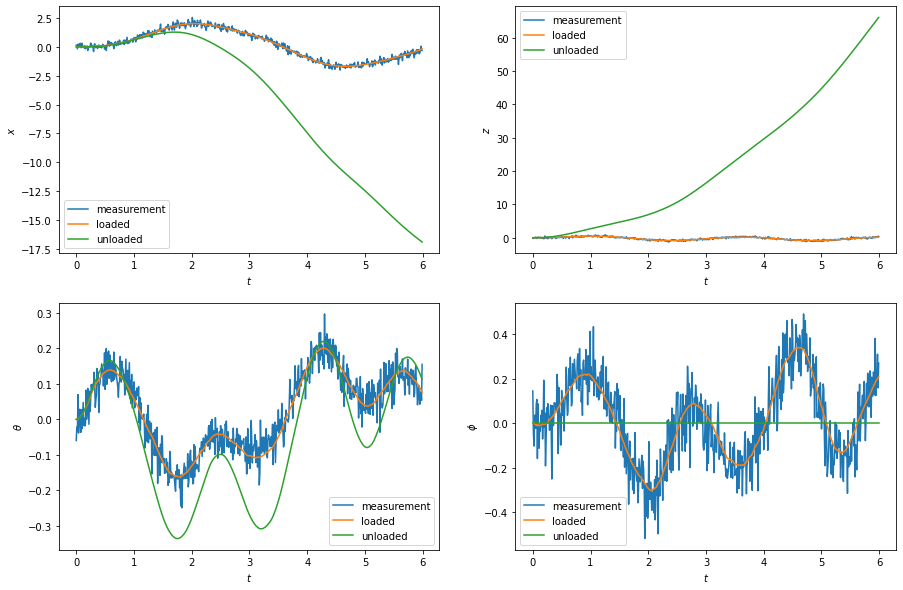

In [61]:
plt.figure(figsize=(15, 10))
symbols = ["$x$", "$z$", r"$\theta$", r"$\phi$"]
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.xlabel("$t$")
    plt.ylabel(symbols[i])
    plt.plot(ts, measures_tn[:, i], label="measurement")
    plt.plot(ts, states_tn[:, i], label="loaded")
    plt.plot(ts, states_nom_tn[:, i], label="unloaded")
    plt.legend()
plt.savefig("plots/nominal.png", dpi=300)

In [25]:
_, anim = animate_2D_quad(ts, states_tn, frameDelay=10, mu=states_nom_tn)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

In [62]:
def UT(mu, sigma, lamb = 2.):
    sigma_sqrt = np.linalg.cholesky(sigma)
    radii = np.sqrt(lamb + mu.shape[0]) * sigma_sqrt
    
    x0 = mu[..., None]
    xi = mu[..., None] + radii
    xin = mu[..., None] - radii
    
    ws = np.zeros(2 * mu.shape[0] + 1)
    ws[0] = lamb / (lamb + mu.shape[0])
    ws[1:] = 1 / (2 * (lamb + mu.shape[0]))
    
    return np.concatenate([x0, xi, xin], axis=-1), ws

def UT_inv(xs, ws):
    mu = xs @ ws
    zs = xs - mu[:, None]
    sigma = np.einsum("ij,kj", zs * ws[None], zs)
    return mu, sigma

In [63]:
mu = np.zeros((num_steps, N))
sigma = np.zeros((num_steps, N, N))
sigma[0] = 0.1 * np.eye(N)

In [64]:
num_UKF_steps = num_steps
num_observable = 4

In [65]:
for i in trange(1, num_UKF_steps):
    # predict
    u = controls_tm[i-1]
    xs, ws = UT(mu[i-1], sigma[i-1])
    xs_bar = np.zeros_like(xs)
    # nominal state
    for j in range(xs.shape[1]):
        xs_bar[:, j] = f_nominal(xs[:, j], u)
    # GP residual
    res, cov = rdl.predict_batch(xs.T, np.repeat(u[None], xs.shape[1], axis=0))
    xs_bar += res.numpy().T
    Q = np.sum(cov.numpy() * ws[:, None, None], axis=0)
    # inverse UT
    mu_pred, sigma_pred = UT_inv(xs_bar, ws)
    sigma_pred += Q + np.diag(Q_scale ** 2)
    
    # update
    xs, ws = UT(mu_pred, sigma_pred)
    ys = xs[:num_observable] # measure first three quantities
    mu_y, sigma_y = UT_inv(ys, ws)
    sigma_y += np.diag(rdl.model.likelihood.variances.numpy()[:num_observable] / 2)
    sigma_xy = np.einsum("ij,kj",
                         (xs - mu_pred[:, None]) * ws[None],
                         ys - mu_y[:, None])
    K = sigma_xy @ np.linalg.inv(sigma_y)
    mu[i] = mu_pred + K @ (measures_tn[i, :num_observable] - mu_y)
    sigma[i] = sigma_pred - K @ sigma_xy.T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 599/599 [00:29<00:00, 20.56it/s]


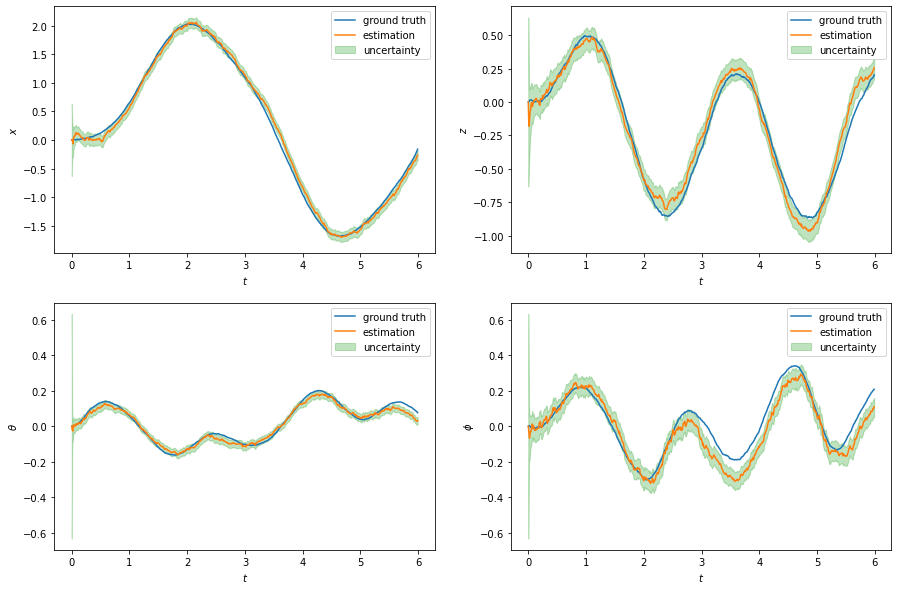

In [66]:
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.xlabel("$t$")
    plt.ylabel(symbols[i])
    plt.plot(ts[:num_UKF_steps], states_tn[:num_UKF_steps, i], label="ground truth")
    plt.plot(ts[:num_UKF_steps], mu[:num_UKF_steps, i], label="estimation")
    std = np.sqrt(sigma[:num_UKF_steps, i, i])
    plt.fill_between(ts[:num_UKF_steps], 
                     mu[:num_UKF_steps, i] - 2 * std, 
                     mu[:num_UKF_steps, i] + 2 * std, alpha=0.3, color="C2", label="uncertainty")
    plt.legend()
plt.savefig("plots/gp_ukf.png", dpi=300)

In [31]:
_, anim = animate_2D_quad(ts, states_tn, frameDelay=10, mu=mu)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

In [32]:
_, anim = animate_2D_quad(ts, states_tn, frameDelay=10, mu=measures_tn)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

## EKF

In [67]:
import Quadcopter

Quadcopter = reload(Quadcopter)
sym_f = Quadcopter.SymbolicFuncsWithMass()

In [68]:
mu = np.zeros((num_steps, 9))
sigma = np.zeros((num_steps, 9, 9))
sigma[0] = 0.1 * np.eye(9)
sigma[0, -1, -1] = 10
Q = np.zeros((9, 9))
Q[:8, :8] = np.diag(Q_scale ** 2)

In [69]:
for i in trange(1, num_steps):
    # predict
    mu_pred = sym_f["f"](mu[i-1], controls_tm[i-1]).flatten()
    A = sym_f["A"](mu[i-1], controls_tm[i-1])
    sigma_pred = A @ sigma[i-1] @ A.T + Q
    
    # update
    C = sym_f["C"](mu_pred)
    S = C @ sigma_pred @ C.T + np.diag(R_scale[:num_observable] ** 2)
    K = sigma_pred @ C.T @ np.linalg.inv(S)
    mu[i] = mu_pred + K @ (measures_tn[i, :num_observable] - sym_f["g"](mu_pred).flatten())
    sigma[i] = sigma_pred - K @ C @ sigma_pred

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 7991.29it/s]


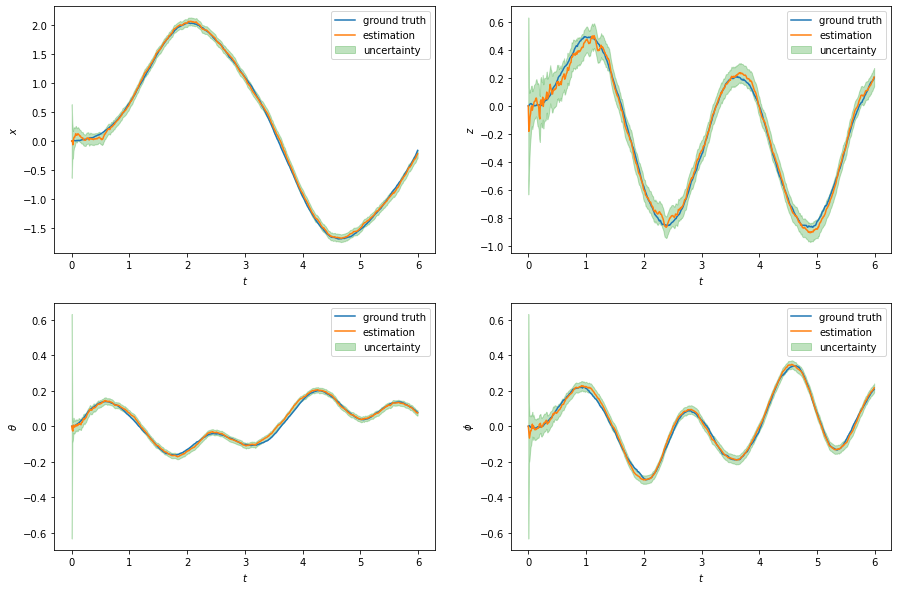

In [70]:
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.xlabel("$t$")
    plt.ylabel(symbols[i])
    plt.plot(ts, states_tn[:, i], label="ground truth")
    plt.plot(ts, mu[:, i], label="estimation")
    std = np.sqrt(sigma[:, i, i])
    plt.fill_between(ts, 
                     mu[:, i] - 2 * std, 
                     mu[:, i] + 2 * std, alpha=0.3, color="C2", label="uncertainty")
    plt.legend()
plt.savefig("plots/ekf.png", dpi=300)

In [45]:
_, anim = animate_2D_quad(ts, states_tn, frameDelay=10, mu=mu)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

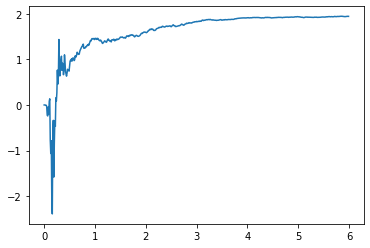

In [67]:
plt.plot(ts, mu[:, -1])

## Random Stuff

In [88]:
states_gt_tn = np.zeros_like(states)
states_nominal_tn = np.zeros_like(states)
states_est_tn = np.zeros_like(states)
VIZ_STEP = 100

for i in trange(1, VIZ_STEP):
    # 8-state to 6-state
    state_6 = states_gt_tn[i-1][[0, 1, 2, 4, 5, 6]]
    control = get_control(state_6, goal_t6[i]).flatten()
    states_gt_tn[i] = f_full(states_gt_tn[i-1], control).flatten()
    
    states_nominal_tn[i] = f_un(states_nominal_tn[i-1], control).flatten()
    
    residual, _ = rdl.predict(states_est_tn[i-1], control)
    states_est_tn[i] = f_un(states_est_tn[i-1], control).flatten() + residual

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:04<00:00, 22.20it/s]


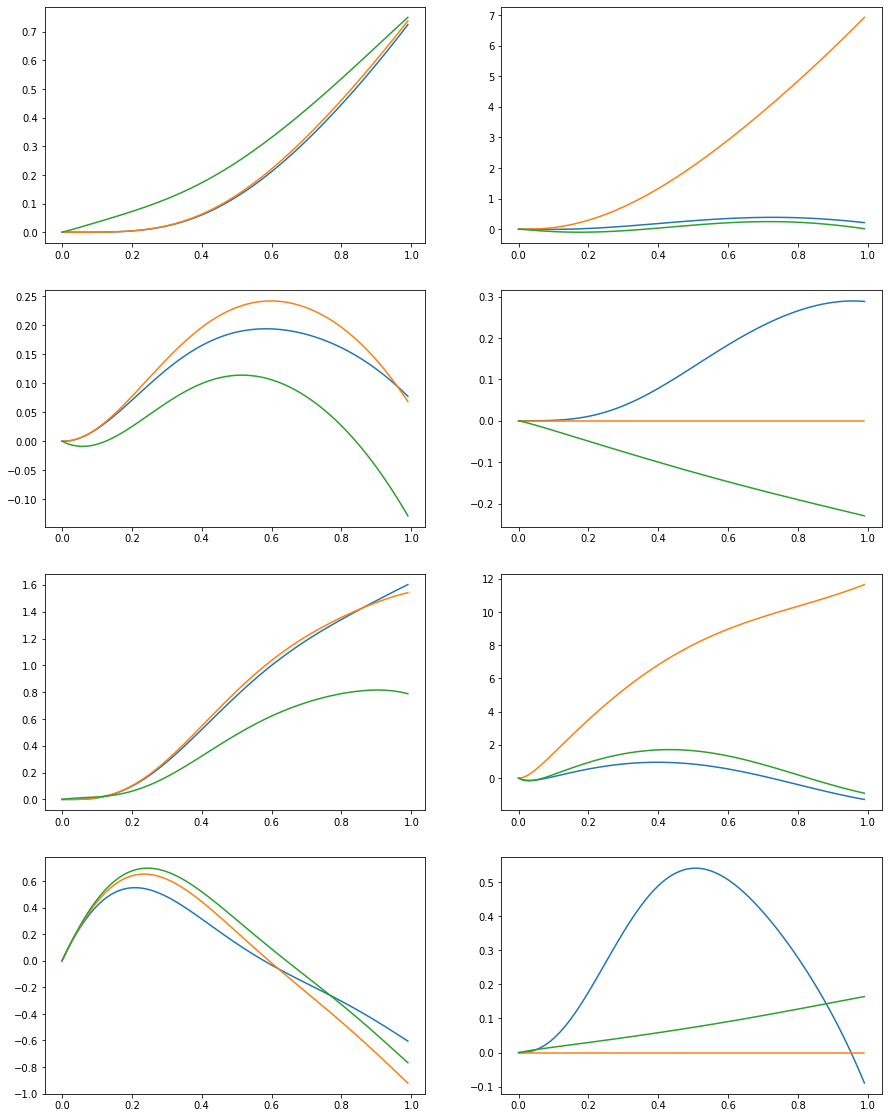

In [89]:
plt.figure(figsize=(15, 20))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(ts[:VIZ_STEP], states_gt_tn[:VIZ_STEP, i])
    plt.plot(ts[:VIZ_STEP], states_nominal_tn[:VIZ_STEP, i])
    plt.plot(ts[:VIZ_STEP], states_est_tn[:VIZ_STEP, i])

In [486]:
idx = 100

In [487]:
res_actual = f_full(states[idx], controls[idx]) - f_un(states[idx], controls[idx])
res_actual = res_actual.flatten()
res_pred, cov = rdl.predict(states[idx], controls[idx])

In [488]:
print(res_pred)
print(res_actual)
print(res_pred - res_actual)

tf.Tensor(
[-0.00791094 -0.00037028 -0.00030806  0.00125114  0.01202189 -0.14298172
  0.01910225 -0.04025956], shape=(8,), dtype=float64)
[ 0.          0.          0.          0.          0.01786304 -0.15799627
  0.00693696 -0.07217586]
tf.Tensor(
[-0.00791094 -0.00037028 -0.00030806  0.00125114 -0.00584116  0.01501455
  0.0121653   0.03191631], shape=(8,), dtype=float64)


In [339]:
np.diag(cov)

array([ 0.00021911,  0.00282102, -0.00481109, -0.00023087,  0.00236225,
        0.00568837,  0.00424954,  0.0023561 ])

In [110]:
rdl.model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.mean_function.c,Parameter,Identity,,True,"(8,)",float64,"[1.47713810e-02, -9.03273934e-05, -1.54618804e-03..."
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.5592598232744539
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[1.85425534, 1.80377935, 1.79497395..."
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.40052580410181504
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[2.32986615, 2.22875437, 2.20919146..."
SVGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.4965254637583381
SVGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[2.01149916, 1.95475705, 1.93884728..."
SVGP.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.5570194177459492
SVGP.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[1.86028649, 1.82263924, 1.80790661..."
SVGP.kernel.kernels[4].variance,Parameter,Softplus,,True,(),float64,0.5777629900133264
